In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes #uncomment if geopy has not been installed 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes #uncomment if folium has not been installed 
import folium # map rendering library

#!pip install BeautifulSoup4
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import ssl
import csv

import urllib.parse
import urllib.error
import ast
import os
from urllib.request import Request, urlopen

#to extract the csv file of latitude and longitude 
import io 

#to deal with regex - regular expressions
import re

#for some plots
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [2]:
#scrape neighborhoods in Minneapolis from wikipedia using BeautifulSoup as bs

url = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Minneapolis")

soup = bs(url.text, "html.parser")

neighborhood = []

for link in soup.find_all("a"):
    neighbor = link.get("title")
    neighborhood.append(neighbor)

neighborhood = list(filter(None.__ne__, neighborhood)) #remove Nonetype in list of neighborhoods
neighborhood = pd.DataFrame(neighborhood)

#cleanup the neighborhood dataframe 
neighborhoodDict = {"neighborhood": []}
for row, neighbor in neighborhood.iterrows(): 
    if 'Minneapolis' in neighbor[0]:
        neighborhoodDict["neighborhood"].append(neighbor[0])

neighborhoodMinn = pd.DataFrame(neighborhoodDict)

#remove rows that are not neighborhoods
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[0, 1, 2, 3, 91, 92]]).reset_index(drop=True)

#cleanup some names of neighborhood in order to locate it later for latitude and longitude

exp = re.compile(r' \(neighborhood\)')
neighborhoodMinn['neighborhood'] = [exp.sub('', x) for x in neighborhoodMinn['neighborhood']]

#Mill District results in Nonetype latitude and longitude values so drop its row
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[51]]).reset_index(drop=True)

#remove Ventura Village because it's located outside Minneapolis - according to FourSquare API
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[76]]).reset_index(drop=True)

#Nicollet Island- East Bank, Minneapolis' returns a NoneType error, so therefore changed it to Nicollet Island
neighborhoodMinn['neighborhood'] = neighborhoodMinn['neighborhood'].replace(['Nicollet Island/East Bank, Minneapolis'],'Nicollet Island, Minneapolis')

neighborhoodMinn.head()

,neighborhood
0,"Armatage, Minneapolis"
1,"Audubon Park, Minneapolis"
2,"Bancroft, Minneapolis"
3,"Beltrami, Minneapolis"
4,"Bottineau, Minneapolis"


In [3]:
# NOTE TO MYSELF: DO NOT RUN THIS CODE CHUNK UNLESS NECESSARY

#this code block takes ~ 45 seconds on my machine due to having to locate latitude and longitude for 85 neighborhoods

latitude = []
longitude = []

geolocator = Nominatim(user_agent="minneapolis_explorer")
for row, neighbor in neighborhoodMinn.iterrows(): 
    location = geolocator.geocode(neighbor[0])
    latitude.append(location.latitude)
    longitude.append(location.longitude)

neighborhoodMinn['latitude'] = latitude
neighborhoodMinn['longitude'] = longitude
neighborhoodMinn.head()

,neighborhood,latitude,longitude
0,"Armatage, Minneapolis",44.897236,-93.310342
1,"Audubon Park, Minneapolis",45.018883,-93.236355
2,"Bancroft, Minneapolis",44.930570,-93.254929
3,"Beltrami, Minneapolis",44.995352,-93.242513
4,"Bottineau, Minneapolis",45.010566,-93.269304


In [4]:
CLIENT_ID = 'TN32UEOPQPWXMDYXAIEPZ3C4G0Q2XG1KOI3K4P5BNBV5NIVL' # your Foursquare ID
CLIENT_SECRET = 'VXCCMMIUMDRIBFPFRPFYT3VK43BHWZ5EIS5UIPVGMITSWDK1' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [5]:
address = 'Minneapolis, Minnesota'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Minneapolis are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minneapolis are 44.9772995, -93.2654692.


In [6]:
# create map of Minneaplis using latitude and longitude values by neighborhood
map_minn_neighborhood = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoodMinn['latitude'], neighborhoodMinn['longitude'], neighborhoodMinn['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minn_neighborhood)  
    
map_minn_neighborhood

In [7]:
neighborhood_df = pd.read_csv('neighborhoodData.csv')
neighborhood_df.head()  

,"Minneapolis, MN - All Homes",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Statistic,NaN,NaN,Zillow Home Value Index,NaN,NaN,NaN,NaN,NaN
1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
2,Minneapolis,city,All Homes,"$291,500",0.30%,0.90%,3.30%,6.30%,3.90%
3,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
4,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%


In [8]:
header_row = 1
neighborhood_df.columns = neighborhood_df.iloc[header_row]
neighborhood_df.head()

1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
0,Statistic,NaN,NaN,Zillow Home Value Index,NaN,NaN,NaN,NaN,NaN
1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
2,Minneapolis,city,All Homes,"$291,500",0.30%,0.90%,3.30%,6.30%,3.90%
3,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
4,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%


In [9]:
neighborhood_df = neighborhood_df.drop(neighborhood_df.index[[0, 1, 2]]).reset_index(drop=True)
neighborhood_df.head()

1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
0,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,neighborhood,All Homes,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,neighborhood,All Homes,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,neighborhood,All Homes,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [10]:
neighborhood_df.rename(columns = {neighborhood_df.columns[0]: 'neighborhood', neighborhood_df.columns[3]: 'zestimatedHVI', neighborhood_df.columns[4]: 'MoM', neighborhood_df.columns[5]: 'QoQ', neighborhood_df.columns[6]: 'YoY', neighborhood_df.columns[7]: 'fiveYearAnnualized', neighborhood_df.columns[8]: 'tenYearAnnualized'}, inplace = True)
neighborhood_df.head()

1,neighborhood,Region Type,Type,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,neighborhood,All Homes,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,neighborhood,All Homes,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,neighborhood,All Homes,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [11]:
neighborhood_df.drop(neighborhood_df.columns[[1, 2]], axis = 1, inplace = True)
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,Armatage,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [12]:
neighborhood_df['neighborhood'] = neighborhood_df['neighborhood'].astype(str) + ', Minneapolis'
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis","$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,"Audubon Park, Minneapolis","$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,"Bancroft, Minneapolis","$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,"Beltrami, Minneapolis","$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,"Bottineau, Minneapolis","$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [13]:
exp = re.compile(r'[$,]')
neighborhood_df['zestimatedHVI'] = [exp.sub('', x) for x in neighborhood_df['zestimatedHVI']]
neighborhood_df.head()


1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.20%,0.50%,2.50%,5.10%,4.20%
1,"Audubon Park, Minneapolis",289500,0.40%,1.00%,6.20%,7.40%,4.50%
2,"Bancroft, Minneapolis",275200,0.20%,0.40%,0.90%,7.10%,4.40%
3,"Beltrami, Minneapolis",256000,0.20%,0.50%,2.20%,7.10%,4.00%
4,"Bottineau, Minneapolis",282100,0.50%,1.50%,6.10%,8.90%,5.40%


In [14]:
exp = re.compile(r'%')
neighborhood_df['MoM'] = [exp.sub('', x) for x in neighborhood_df['MoM']]
neighborhood_df['QoQ'] = [exp.sub('', x) for x in neighborhood_df['QoQ']]
neighborhood_df['YoY'] = [exp.sub('', x) for x in neighborhood_df['YoY']]
neighborhood_df['fiveYearAnnualized'] = [exp.sub('', x) for x in neighborhood_df['fiveYearAnnualized']]
neighborhood_df['tenYearAnnualized'] = [exp.sub('', x) for x in neighborhood_df['tenYearAnnualized']]

neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.20,0.50,2.50,5.10,4.20
1,"Audubon Park, Minneapolis",289500,0.40,1.00,6.20,7.40,4.50
2,"Bancroft, Minneapolis",275200,0.20,0.40,0.90,7.10,4.40
3,"Beltrami, Minneapolis",256000,0.20,0.50,2.20,7.10,4.00
4,"Bottineau, Minneapolis",282100,0.50,1.50,6.10,8.90,5.40


In [15]:
neighborhood_df.dtypes

1
neighborhood          object
zestimatedHVI         object
MoM                   object
QoQ                   object
YoY                   object
fiveYearAnnualized    object
tenYearAnnualized     object
dtype: object

In [16]:
neighborhood_df[["zestimatedHVI", "MoM", "QoQ", "YoY", "fiveYearAnnualized", "tenYearAnnualized"]] = neighborhood_df[["zestimatedHVI", "MoM", "QoQ", "YoY", "fiveYearAnnualized", "tenYearAnnualized"]].apply(pd.to_numeric, errors = 'coerce')
neighborhood_df.dtypes

1
neighborhood           object
zestimatedHVI           int64
MoM                   float64
QoQ                   float64
YoY                   float64
fiveYearAnnualized    float64
tenYearAnnualized     float64
dtype: object

In [17]:
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.2,0.5,2.5,5.1,4.2
1,"Audubon Park, Minneapolis",289500,0.4,1.0,6.2,7.4,4.5
2,"Bancroft, Minneapolis",275200,0.2,0.4,0.9,7.1,4.4
3,"Beltrami, Minneapolis",256000,0.2,0.5,2.2,7.1,4.0
4,"Bottineau, Minneapolis",282100,0.5,1.5,6.1,8.9,5.4


In [18]:
#function to repeat the same process to all the neighborhoods in Minneapolis

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
#DON'T LOAD THIS UNLESS COMPLETELY NECESSARY

minneapolis_venues = getNearbyVenues(names=neighborhoodMinn['neighborhood'],
                                   latitudes=neighborhoodMinn['latitude'],
                                   longitudes=neighborhoodMinn['longitude']
                                  )

print(minneapolis_venues.shape)

Armatage, Minneapolis
Audubon Park, Minneapolis
Bancroft, Minneapolis
Beltrami, Minneapolis
Bottineau, Minneapolis
Bryant, Minneapolis
Bryn Mawr, Minneapolis
Cedar-Isles-Dean, Minneapolis
Cedar-Riverside, Minneapolis
Central, Minneapolis
Cleveland, Minneapolis
Columbia Park, Minneapolis
Como, Minneapolis
Cooper, Minneapolis
Corcoran, Minneapolis
Diamond Lake, Minneapolis
Downtown East, Minneapolis
Downtown West, Minneapolis
East Calhoun, Minneapolis
East Harriet, Minneapolis
East Isles, Minneapolis
East Phillips, Minneapolis
Elliot Park, Minneapolis
Ericsson, Minneapolis
Field, Minneapolis
Folwell, Minneapolis
Fulton, Minneapolis
Hale, Minneapolis
Harrison, Minneapolis
Hawthorne, Minneapolis
Hiawatha, Minneapolis
Holland, Minneapolis
Howe, Minneapolis
Jordan, Minneapolis
Keewaydin, Minneapolis
Kenny, Minneapolis
Kenwood, Minneapolis
King Field, Minneapolis
Lind-Bohanon, Minneapolis
Linden Hills, Minneapolis
Logan Park, Minneapolis
Longfellow, Minneapolis
Lowry Hill East, Minneapolis
Lo

In [20]:
minneapolis_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Armatage, Minneapolis",44.897236,-93.310342,Armatage Park,44.899459,-93.310883,Park
1,"Armatage, Minneapolis",44.897236,-93.310342,Domino's Pizza,44.894770,-93.308208,Pizza Place
2,"Armatage, Minneapolis",44.897236,-93.310342,"Wagner Greenhouses, Inc.",44.892827,-93.309378,Flower Shop
3,"Armatage, Minneapolis",44.897236,-93.310342,Campbell Ron Interiors,44.897104,-93.307806,Furniture / Home Store
4,"Armatage, Minneapolis",44.897236,-93.310342,Minnehaha Creek,44.897722,-93.311425,Trail


In [21]:
#how many venues were returned for each neighborhood

neighborhoodVenues = minneapolis_venues.groupby('Neighborhood').count()
neighborhoodVenues.drop(neighborhoodVenues.columns[[1, 2, 3, 4, 5]], axis = 1, inplace = True)
neighborhoodVenues.reset_index(level=0, inplace=True)
neighborhoodVenues.rename(columns = {'Neighborhood': 'neighborhood', 'Neighborhood Latitude': 'count'}, inplace = True)
neighborhoodVenues
#problem: some neighborhoods are very small. eg: Hawthorne, Minneapolis	only has 2 venues 
#to think about: do we want to drop neighborhoods that are very small, or increase the radius?

,neighborhood,count
0,"Armatage, Minneapolis",7
1,"Audubon Park, Minneapolis",19
2,"Bancroft, Minneapolis",4
3,"Beltrami, Minneapolis",8
4,"Bottineau, Minneapolis",15
5,"Bryant, Minneapolis",6
6,"Bryn Mawr, Minneapolis",8
7,"Cedar-Isles-Dean, Minneapolis",7
8,"Cedar-Riverside, Minneapolis",27
9,"Central, Minneapolis",30


In [22]:
#how many unique categories can be curated from all the returned values

print('There are {} uniques categories.'.format(len(minneapolis_venues['Venue Category'].unique())))

There are 223 uniques categories.


In [23]:
#one hot encoding to put the unique categories in columns
minneapolis_onehot = pd.get_dummies(minneapolis_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
minneapolis_onehot['Neighborhood'] = minneapolis_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [minneapolis_onehot.columns[-1]] + list(minneapolis_onehot.columns[:-1])
minneapolis_onehot = minneapolis_onehot[fixed_columns]

minneapolis_onehot.head()

,Neighborhood,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Armatage, Minneapolis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [24]:
minneapolis_onehot.shape

(1039, 224)

In [25]:
#group rows by neighborhood, take the mean of the frequency of occurrence of each category
 
minneapolis_grouped = minneapolis_onehot.groupby('Neighborhood').mean().reset_index()
minneapolis_grouped.head()

,Neighborhood,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000000,0.0,0.0,0.

In [26]:
minneapolis_grouped.shape

(85, 224)

In [27]:
#print each neighborhood along with the top 5 most common venues

num_top_venues = 10

for hood in minneapolis_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = minneapolis_grouped[minneapolis_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

ount Store  0.11
5  Construction & Landscaping  0.11
6              Sandwich Place  0.11
7                   Gift Shop  0.11
8           Food & Drink Shop  0.11
9        Outdoor Supply Store  0.00


----Keewaydin, Minneapolis----
                   venue  freq
0            Yoga Studio  0.17
1               Boutique  0.17
2              Gift Shop  0.17
3            Coffee Shop  0.17
4                   Park  0.17
5                  Beach  0.17
6  Performing Arts Venue  0.00
7             Non-Profit  0.00
8            Opera House  0.00
9           Optical Shop  0.00


----Kenny, Minneapolis----
                        venue  freq
0  Construction & Landscaping  0.33
1                       Plaza  0.33
2                        Park  0.33
3                         ATM  0.00
4       Performing Arts Venue  0.00
5                 Music Venue  0.00
6     New American Restaurant  0.00
7                  Non-Profit  0.00
8                 Opera House  0.00
9                Optical Shop  0.00


--

In [28]:
#function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
#create the new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minneapolis_grouped['Neighborhood']

for ind in np.arange(minneapolis_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minneapolis_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Skate Park,Convenience Store,Flower Shop,Pizza Place,Furniture / Home Store,Trail,Park,Eastern European Restaurant,Fishing Spot,Fish & Chips Shop
1,"Audubon Park, Minneapolis",Cosmetics Shop,Convenience Store,Pharmacy,Hotel Bar,Bakery,Restaurant,Park,Coffee Shop,Clothing Store,Chinese Restaurant
2,"Bancroft, Minneapolis",Ice Cream Shop,Discount Store,Southern / Soul Food Restaurant,Caribbean Restaurant,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot
3,"Beltrami, Minneapolis",Convenience Store,Asian Restaurant,Brewery,Café,Coffee Shop,Gay Bar,Chinese Restaurant,Playground,Fishing Spot,Farmers Market
4,"Bottineau, Minneapolis",Theme Restaurant,Bar,Park,Art Gallery,Beer Garden,Coffee Shop,Gym,German Restaurant,New American Restaurant,Furniture / Home Store


In [30]:
minneapolis_grouped = neighborhood_df.join(minneapolis_grouped.set_index('Neighborhood'), on='neighborhood') 
minneapolis_grouped.head()

,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",360400,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0

In [31]:
minneapolis_grouped.shape

(85, 230)

In [32]:
minneapolis_grouped = neighborhoodMinn.join(minneapolis_grouped.set_index('neighborhood'), on='neighborhood')
minneapolis_grouped.shape

(85, 232)

In [33]:
minneapolis_grouped.head()

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [34]:
minneapolis_grouped = minneapolis_grouped.dropna()

In [35]:
minneapolis_grouped.describe()

,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
count,64.000000,64.000000,6.400000e+01,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.0,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.0,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.000000,64.000000,64.0,64.000000,64.000000,64.000000,64.000000,64.000000,64.0,64.00000

In [36]:
minneapolis_grouped_clustering = minneapolis_grouped.drop(minneapolis_grouped.columns[[0,1,2]], 1)
minneapolis_grouped_clustering.head()

,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
0,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0

In [37]:
minneapolis_grouped_clustering.shape

(64, 229)

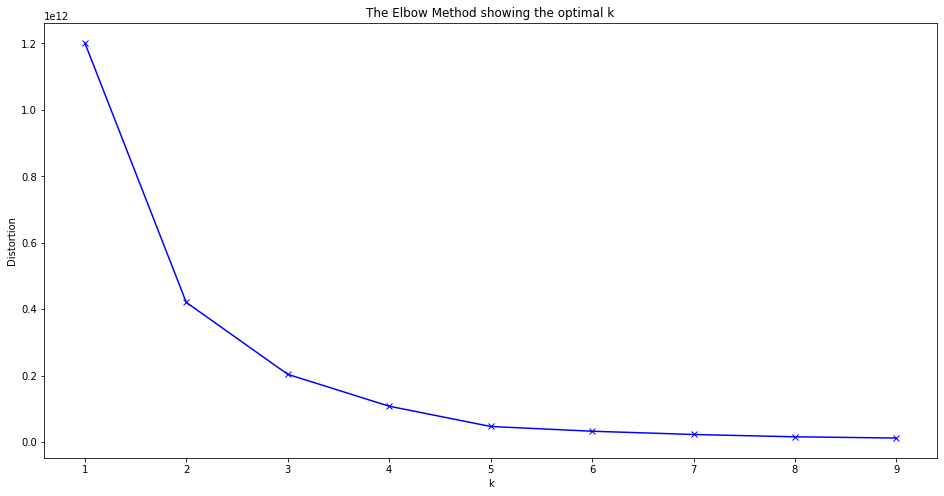

In [38]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(minneapolis_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [39]:
np.random.seed(0)
# from elbow method, set number of clusters to 3
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(minneapolis_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0], dtype=int32)

In [40]:
labels = kmeans.labels_
print(labels)

[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 2 0 0 0
 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [41]:
neighborhoods_venues_sorted.shape

(85, 11)

In [42]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Skate Park,Convenience Store,Flower Shop,Pizza Place,Furniture / Home Store,Trail,Park,Eastern European Restaurant,Fishing Spot,Fish & Chips Shop
1,"Audubon Park, Minneapolis",Cosmetics Shop,Convenience Store,Pharmacy,Hotel Bar,Bakery,Restaurant,Park,Coffee Shop,Clothing Store,Chinese Restaurant
2,"Bancroft, Minneapolis",Ice Cream Shop,Discount Store,Southern / Soul Food Restaurant,Caribbean Restaurant,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot
3,"Beltrami, Minneapolis",Convenience Store,Asian Restaurant,Brewery,Café,Coffee Shop,Gay Bar,Chinese Restaurant,Playground,Fishing Spot,Farmers Market
4,"Bottineau, Minneapolis",Theme Restaurant,Bar,Park,Art Gallery,Beer Garden,Coffee Shop,Gym,German Restaurant,New American Restaurant,Furniture / Home Store


In [43]:
minneapolis_grouped = minneapolis_grouped.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')
minneapolis_grouped.head()

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0

In [44]:
# add clustering labels
minneapolis_grouped["Labels"] = labels
minneapolis_grouped.head(5)

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.00,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.000000,0.0,0.

In [45]:
minneapolis_grouped.to_csv('finalLocation_minneapolisNeighborhood.csv')

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minneapolis_grouped['latitude'], minneapolis_grouped['longitude'], minneapolis_grouped['neighborhood'], minneapolis_grouped['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [47]:
#examine clusters

#CLUSTER 1

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 0, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]



,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",360400.0,Skate Park,Convenience Store,Flower Shop,Pizza Place,Furniture / Home Store,Trail,Park,Eastern European Restaurant,Fishing Spot,Fish & Chips Shop
1,"Audubon Park, Minneapolis",289500.0,Cosmetics Shop,Convenience Store,Pharmacy,Hotel Bar,Bakery,Restaurant,Park,Coffee Shop,Clothing Store,Chinese Restaurant
2,"Bancroft, Minneapolis",275200.0,Ice Cream Shop,Discount Store,Southern / Soul Food Restaurant,Caribbean Restaurant,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot
3,"Beltrami, Minneapolis",256000.0,Convenience Store,Asian Restaurant,Brewery,Café,Coffee Shop,Gay Bar,Chinese Restaurant,Playground,Fishing Spot,Farmers Market
4,"Bottineau, Minneapolis",282100.0,Theme Restaurant,Bar,Park,Art Gallery,Beer Garden,Coffee Shop,Gym,German Restaurant,New American Restaurant,Furniture / Home Store
5,"Bryant, Minneapolis",271300.0,Dive Bar,Construction & Landscaping,Food Truck,Deli / Bodega,American Restaurant,Park,Yoga Studio,Farmers Market,Fast Food Restaurant,Film Studio
8,"Cedar-Riverside, Minneapolis",182900.0,Theater,Sandwich Place,Bar,ATM,Greek Restaurant,Concert Hall,Dive Bar,College Residence Hall,Rock Club,Coffee Shop
9,"Central, Minneapolis",262800.0,Coffee Shop,Food Truck,Bar,Yoga Studio,Salad Place,New American Restaurant,Event Space,Sushi Restaurant,Music Venue,Japanese Restaurant
10,"Cleveland, Minneapolis",198600.0,Food Truck,Music Venue,Trail,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot,Fish & Chips Shop,Film Studio
11,"Columbia Park, Minneapolis",252600.0,Gym,Motorcycle Shop,Skate Park,Arts & Crafts Store,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot,Fish & Chips Shop,Film Studio


In [48]:
#CLUSTER 2

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 1, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Bryn Mawr, Minneapolis",430100.0,Intersection,Men's Store,Coffee Shop,Furniture / Home Store,Antique Shop,Pizza Place,Sandwich Place,Grocery Store,Event Space,Farmers Market
7,"Cedar-Isles-Dean, Minneapolis",534100.0,Sporting Goods Shop,Bridge,Speakeasy,Beach,American Restaurant,Tourist Information Center,Gym / Fitness Center,Film Studio,Farmers Market,Fast Food Restaurant
16,"Downtown East, Minneapolis",554800.0,Coffee Shop,Japanese Restaurant,Bar,Pub,Hotel,Music Venue,Seafood Restaurant,Sandwich Place,Public Art,Park
18,"East Calhoun, Minneapolis",534000.0,Cosmetics Shop,Ice Cream Shop,Scenic Lookout,Bakery,Beach,Yoga Studio,English Restaurant,Food Court,Food & Drink Shop,Flower Shop
19,"East Harriet, Minneapolis",401600.0,Park,Garden,Carpet Store,Pub,American Restaurant,Intersection,Film Studio,Event Space,Farmers Market,Fast Food Restaurant
20,"East Isles, Minneapolis",463200.0,Coffee Shop,Pizza Place,Mexican Restaurant,Boutique,Electronics Store,Supermarket,Sandwich Place,Tea Room,Smoke Shop,Italian Restaurant
26,"Fulton, Minneapolis",515500.0,Antique Shop,Thrift / Vintage Store,Art Gallery,Gourmet Shop,Clothing Store,Coffee Shop,Pet Store,Shipping Store,Pizza Place,Film Studio
27,"Hale, Minneapolis",401000.0,Furniture / Home Store,Playground,Breakfast Spot,Thrift / Vintage Store,Yoga Studio,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot
35,"Kenny, Minneapolis",380400.0,Construction & Landscaping,Plaza,Park,Dance Studio,Electronics Store,Food Court,Food & Drink Shop,Flower Shop,Fishing Spot,Fish & Chips Shop
43,"Lowry Hill, Minneapolis",661900.0,Restaurant,Bar,Steakhouse,Liquor Store,Gift Shop,Ice Cream Shop,Mexican Restaurant,American Restaurant,Acupuncturist,Food & Drink Shop


In [49]:
#CLUSTER 3

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 2, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,"Kenwood, Minneapolis",1017600.0,School,Bookstore,Baseball Field,New American Restaurant,Bakery,Skating Rink,Tailor Shop,Park,Arts & Crafts Store,Café


In [50]:
minneapolis_grouped.groupby('Labels').mean()

,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Border Crossing,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fishing Spot,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Martial Arts School,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Venue,New American Restaurant,Non-Profit,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pilates Studio,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Southern / Soul Food Restaurant,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Winery,Women's Store,Yoga Studio
Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,44.967050,-93.260985,2.631118e+05,0.366667,1.001961,4.262745,7.454902,4.215686,0.000726,0.003268,0.002801,0.000726,0.017009,0.004648,0.001961,0.021148,0.006460,0.008325,0.0,0.006735,0.000726,0.018878,0.001885,0.016328,0.009804,0.003268,0.000726,0.000654,0.005229,0.000654,0.001307,0.0,0.005556,0.019608,0.004774,0.002064,0.005229,0.011892,0.000726,0.000000,0.001307,0.007907,0.012055,0.001307,0.009337,0.0,0.016639,0.010131,0.000000,0.0,0.012511,0.0,0.014023,0.000654,0.053679,

In [51]:
homeVal = pd.read_csv('homeInfo.csv')
homeVal.rename(columns = {'address/streetAddress': 'street', 'address/zipcode': 'zipcode', 'livingArea': 'sqft'}, inplace = True)
homeVal.drop(list(homeVal.filter(regex = 'address')), axis = 1, inplace = True)
homeVal.drop(list(homeVal.filter(regex = 'photos')), axis = 1, inplace = True)
homeVal.drop(homeVal.columns[[4]], axis = 1, inplace = True)
homeVal.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood
0,6031 Thomas Ave S,55410,2.0,4.0,Welcome home to this immaculate rambler in a p...,44.893323,2031.0,-93.313384,395000.0,https://www.zillow.com/homedetails/6031-Thomas...,1958.0,"Armantage, Minneapolis"
1,5504 Richmond Curv,55410,3.0,4.0,Picturesque and meticulously maintained Armata...,44.903069,2276.0,-93.311553,585000.0,https://www.zillow.com/homedetails/5504-Richmo...,1965.0,"Armantage, Minneapolis"
2,5737 Sheridan Ave S,55410,2.0,3.0,This 1953 Rambler has great curb appeal in thi...,44.898643,1914.0,-93.312114,350000.0,https://www.zillow.com/homedetails/5737-Sherid...,1953.0,"Armantage, Minneapolis"
3,5822 Upton Ave S,55410,3.0,4.0,Beautiful almost new home with an incredible k...,44.897210,2847.0,-93.315378,739900.0,https://www.zillow.com/homedetails/5822-Upton-...,2014.0,"Armantage, Minneapolis"
4,5520 Morgan Ave S,55419,2.0,4.0,Located in one of the sweetest blocks in Armat...,44.902484,1808.0,-93.305194,447000.0,https://www.zillow.com/homedetails/5520-Morgan...,1949.0,"Armantage, Minneapolis"


In [52]:
print(homeVal.shape)
homeVal.dropna(how='any', inplace=True)
print(homeVal.shape)

(869, 12)
(811, 12)


In [53]:
homeVal[["bathrooms", "bedrooms", "sqft", "price", "yearBuilt"]] = homeVal[["bathrooms", "bedrooms", "sqft", "price", "yearBuilt"]].astype(int)
homeVal.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood
0,6031 Thomas Ave S,55410,2,4,Welcome home to this immaculate rambler in a p...,44.893323,2031,-93.313384,395000,https://www.zillow.com/homedetails/6031-Thomas...,1958,"Armantage, Minneapolis"
1,5504 Richmond Curv,55410,3,4,Picturesque and meticulously maintained Armata...,44.903069,2276,-93.311553,585000,https://www.zillow.com/homedetails/5504-Richmo...,1965,"Armantage, Minneapolis"
2,5737 Sheridan Ave S,55410,2,3,This 1953 Rambler has great curb appeal in thi...,44.898643,1914,-93.312114,350000,https://www.zillow.com/homedetails/5737-Sherid...,1953,"Armantage, Minneapolis"
3,5822 Upton Ave S,55410,3,4,Beautiful almost new home with an incredible k...,44.897210,2847,-93.315378,739900,https://www.zillow.com/homedetails/5822-Upton-...,2014,"Armantage, Minneapolis"
4,5520 Morgan Ave S,55419,2,4,Located in one of the sweetest blocks in Armat...,44.902484,1808,-93.305194,447000,https://www.zillow.com/homedetails/5520-Morgan...,1949,"Armantage, Minneapolis"


In [54]:
homeVal.to_csv('finalHomeVal_minneapolisNeighborhood.csv')

In [55]:
def getNearbyVenues2(names, neighbors, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, neighbor, lat, lng in zip(names, neighbors, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            neighbor,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['street',
                'neighborhood',
                'streetLatitude', 
                'streetLongitude', 
                'venue', 
                'venueLatitude', 
                'venueLongitude', 
                'venueCategory']
    
    return(nearby_venues)



In [58]:
homeVal.dropna(inplace = True)

In [59]:
#DON'T LOAD THIS UNLESS COMPLETELY NECESSARY

home_venues = getNearbyVenues2(names=homeVal['street'],
                                neighbors = homeVal['neighborhood'],
                                latitudes=homeVal['latitude'],
                                longitudes=homeVal['longitude'])

print(home_venues.shape)


6031 Thomas Ave S
5504 Richmond Curv
5737 Sheridan Ave S
5822 Upton Ave S
5520 Morgan Ave S
2521 W 60th St
5904 Upton Ave S
5929 Washburn Ave S
5853 Xerxes Ave S
6020 Thomas Ave S
5904 Russell Ave S
6112 Sheridan Ave S
5729 Morgan Ave S
5925 Washburn Ave S
5908 Morgan Ave S
5926 Penn Ave S
5615 Penn Ave S
1106 26th Ave NE
2723 Lincoln St NE
2922 Lincoln St NE
2504 Garfield St NE
2559 Cleveland St NE
2634 Benjamin St NE
3024 Buchanan St NE
2723 Pierce St NE
2957 Pierce St NE
1209 29th Ave NE
2614 Polk St NE
3821 16th Ave S
3901 12th Ave S
4017 Elliot Ave
3949 14th Ave S
3824 Elliot Ave
4114 Cedar Ave S
1405 E 40th St APT 9F
3825 18th Ave S
3848 Elliot Ave
4123 18th Ave S
4001 Elliot Ave
4116 13th Ave S
3849 10th Ave S
3816 Cedar Ave S
3824 10th Ave S
4041 10th Ave S
613 Harrison St NE
436 Buchanan St NE
310 Pierce St NE
64 23rd Ave NE
1815 3rd St NE
4015 5th Ave S
4049 5th Ave S
3821 4th Ave S
3929 Clinton Ave
4151 2nd Ave S
733 E 41st St
4004 5th Ave S
4120 Oakland Ave
3928 Oakland Ave

In [60]:
home_venues.to_csv('home_venues.csv')

In [121]:
home_venues = pd.read_csv('home_venues.csv')
home_venues.drop(home_venues.columns[[0]], axis = 1, inplace = True)

home_venues.head()

,street,neighborhood,streetLatitude,streetLongitude,venue,venueLatitude,venueLongitude,venueCategory
0,6031 Thomas Ave S,"Armantage, Minneapolis",44.893323,-93.313384,"Wagner Greenhouses, Inc.",44.892827,-93.309378,Flower Shop
1,6031 Thomas Ave S,"Armantage, Minneapolis",44.893323,-93.313384,Domino's Pizza,44.894770,-93.308208,Pizza Place
2,6031 Thomas Ave S,"Armantage, Minneapolis",44.893323,-93.313384,Goat Cheese Heaven,44.896551,-93.312107,Greek Restaurant
3,6031 Thomas Ave S,"Armantage, Minneapolis",44.893323,-93.313384,Super USA,44.894608,-93.308577,Convenience Store
4,6031 Thomas Ave S,"Armantage, Minneapolis",44.893323,-93.313384,"Bus Stop for Metro Transit Bus 6C, E, & K.",44.893887,-93.318764,Bus Station


In [122]:
#how many venues were returned for each street

homeVenues = home_venues.groupby('street').count()
homeVenues.drop(homeVenues.columns[[1, 2, 3, 4, 5, 6]], axis = 1, inplace = True)
homeVenues.reset_index(level=0, inplace=True)
homeVenues.rename(columns = {'neighborhood': 'count'}, inplace = True)
homeVenues.head(10)


,street,count
0,1000 E 51st St,3
1,1007 24th Ave NE,23
2,1012 24th Ave NE,27
3,1014 Portland Ave S,29
4,1015 W 28th St,30
5,1020 E 25th St,4
6,1021 W 60th St,5
7,10241 3rd St NE #F,30
8,1044 18th Ave NE,12
9,1071 Antoinette Ave S,5


In [123]:
#one hot encoding to put the unique categories in columns
home_onehot = pd.get_dummies(home_venues[['venueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
home_onehot['street'] = home_venues['street'] 
home_onehot['neighborhood'] = home_venues['neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [home_onehot.columns[-2]] + list(home_onehot.columns[:-2])
home_onehot = home_onehot[fixed_columns]

home_onehot.head()

,street,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaura

In [124]:
#TAKES LONG, DON'T RUN UNLESS NECESSARY
home_grouped = home_onehot.groupby('street').mean().reset_index()
home_grouped.head()

,street,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaura

In [125]:
home_grouped = homeVal.join(home_grouped.set_index('street'), on='street')
home_grouped.shape

(811, 323)

In [126]:
home_grouped.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Rest

In [127]:
#NO NEED TO DO THIS ANYMORE. k = 3
home_grouped_clustering = home_grouped.drop(home_grouped.columns[[0,1,4,5,7,9,11]], 1)
home_grouped_clustering.dropna(inplace = True)

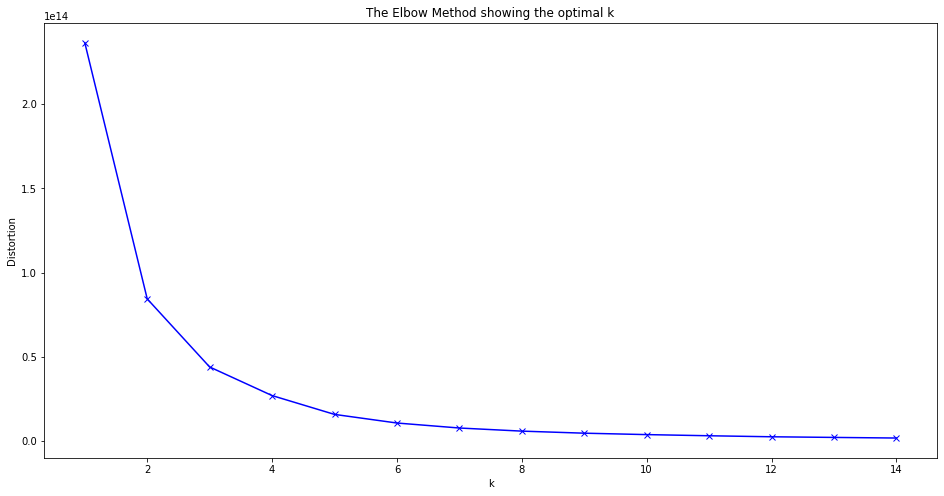

In [128]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(home_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [129]:
np.random.seed(0)
# from elbow method, set number of clusters to 3
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(home_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

In [130]:
labels = kmeans.labels_
print(labels)

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1
 1 1 1 2 0 1 1 1 0 1 2 0 2 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 2 0 1 1 1
 0 0 0 2 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 2 2 1 1 1 1 0 1 0 0 1 0 1 2 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1
 1 2 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1
 1 1 0 0 2 1 1 2 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0
 0 0 1 0 0 0 0 2 1 2 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [131]:
len(labels)

808

In [132]:
home_grouped.dropna(inplace = True)

In [133]:
home_grouped.shape

(808, 323)

In [134]:
home_grouped_clustering.shape

(808, 316)

In [135]:
home_grouped_clustering['street'] = home_grouped['street']

In [137]:
home_grouped['Labels'] = labels
home_grouped.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Rest

In [147]:
map_clusters_home = folium.Map(location=[latitude, longitude], zoom_start=11.6)

mn_geo = r'mnNeighborhood.geojson'

map_clusters_home.choropleth(geo_data = mn_geo, 
              data = neighborhoodVenues,
              columns = ['neighborhood', 'count'],
              key_on = 'feature.properties.BDNAME',
              fill_color = 'YlOrRd', 
              fill_opacity = 0, 
              line_opacity = 0.4,
              highlight=True,
              reset=True)


folium.LayerControl().add_to(map_clusters_home)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(home_grouped['latitude'], home_grouped['longitude'], home_grouped['zipcode'], home_grouped['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_home)
       

               
map_clusters_home

In [ ]:
#examine clusters

#CLUSTER 1

home_grouped.loc[home_grouped['Labels'] == 0, minneapolis_grouped.columns[[0, 3, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2]]]


In [148]:
home_grouped.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Cuban Restaurant,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Rest

In [156]:
finaldf = home_grouped.groupby('Labels').mean()
finaldf = finaldf.loc[:,finaldf.columns[[1, 2, 4, 6, 7]]]
finaldf.head()

,bathrooms,bedrooms,sqft,price,yearBuilt
Labels,,,,,
0,1.867982,3.021244,1611.693475,3.169008e+05,1935.657056
1,3.875969,4.069767,3631.589147,1.070467e+06,1950.007752
2,4.950000,4.450000,5647.450000,3.033235e+06,1951.250000


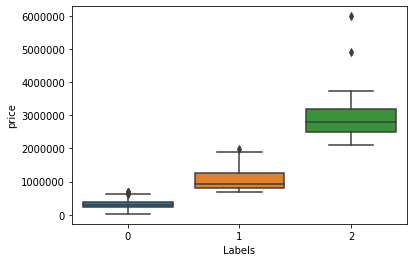

In [157]:
import seaborn as sns
sns.boxplot(x="Labels", y="price", data=home_grouped)

In [158]:
home_grouped.corr()['price'].sort_values()

longitude                         -0.238738
zipcode                           -0.164550
Convenience Store                 -0.123604
Discount Store                    -0.115519
Liquor Store                      -0.113829
BBQ Joint                         -0.113149
Grocery Store                     -0.112470
Fast Food Restaurant              -0.108019
Food & Drink Shop                 -0.106319
Chinese Restaurant                -0.099347
latitude                          -0.095311
Food Truck                        -0.090359
Restaurant                        -0.080120
Asian Restaurant                  -0.076876
Shoe Store                        -0.074638
Mexican Restaurant                -0.074067
Gym                               -0.072439
Dive Bar                          -0.072070
Music Store                       -0.071461
Pharmacy                          -0.069020
Bus Station                       -0.068459
Ramen Restaurant                  -0.063267
Burger Joint                    

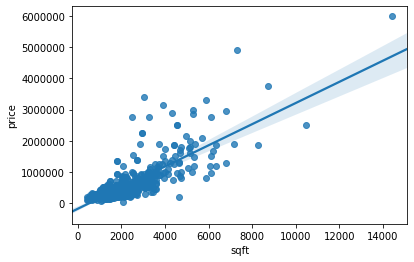

In [160]:
sns.regplot(x = "sqft", y = "price", data = home_grouped)